# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 2A: Advanced Concepts I

This notebook is provides an introduction to conditional statements, math functions as well externals in GT4PY.

In [1]:
# standard packages
import matplotlib.pyplot as plt
import numpy as np

# import GT4Py
import gt4py
from gt4py import gtscript

# some useful tools used in this notebook (mostly plotting)
from tools import plot_two_ij_slices, plot_three_ij_slices, print_generated_code

### Setup

Setup size of computational domain `(nx, ny, 1)` and the width of the halo region `nhalo`. We use a single vertical level here for simplicity and ease of visualization of inputs and outputs.

Create two storages we can use as input and output fields for stencils.

In [2]:
# Setting up the domain
nx = ny = 32
nhalo = 3
shape = (nx + 2*nhalo, ny + 2*nhalo, 1)

# and the storages
in_field = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

out_field = in_field.copy()

filter_field = in_field.copy()

We'll also define a couple of convenience functions that we'll use frequently below.

In [3]:
def set_box_to_value(field, value=1.):
    field[:] = 0.
    field[nhalo + nx // 4 : nhalo +  3 * nx  // 4, nhalo + ny // 4 : nhalo + 3 * ny // 4, :] = value
    
def set_box_to_stripe_pattern(field, value=1.):
    field[:] = 0.
    field[nhalo + nx // 4 : nhalo +  3 * nx  // 4 : 2, nhalo + ny // 4 : nhalo + 3 * ny // 4, :] = value
    
def set_box_to_checkerboard_pattern(field, value=1.):
    field[:] = 0.
    field[nhalo + nx // 4 : nhalo +  3 * nx  // 4 : 2, nhalo + ny // 4 : nhalo + 3 * ny // 4, :] = value
    field[nhalo + nx // 4 + 1 : nhalo + 3 * nx // 4 : 2, nhalo + ny // 4 : nhalo + 3 * ny // 4, :] = -value
    field[nhalo + nx // 4 : nhalo + 3 * nx // 4, nhalo + ny // 4 : nhalo + 3 * ny // 4 : 2, :] *= -1.
    
def set_box_to_gradient(field):
    field[:] = 0.
    for i in range(nx // 2):
        field[nhalo + nx // 4 + i, nhalo + ny // 4 : nhalo + 3 * ny // 4, :] = i + 1

## Scalar Conditionals

Conditionals can be specified using a scalar or a field. The most common use case in a typical atmospheric code probably are conditionals on scalars, for example for selecting the order of an interpolation or checking whether the timestep is positive or negative during initialization. Scalar conditionals in GT4Py behave fairly intuitively.

In [4]:
@gtscript.stencil(backend="numpy")
def conditional_stencil(in_field: gtscript.Field[float], out_field: gtscript.Field[float], c: float):
    with computation(PARALLEL), interval(...):
        if c > 0.:
            out_field = in_field + in_field[1, 0, 0]
        else:
            out_field = in_field - in_field[1, 0, 0]

We initialize the input storage with a stripe pattern (alternating vertical lines of value 2. and 0.) in an inner square region. If we pass `c = 1.` in our stencil call, we'll execute along one branch for all gridpoints.

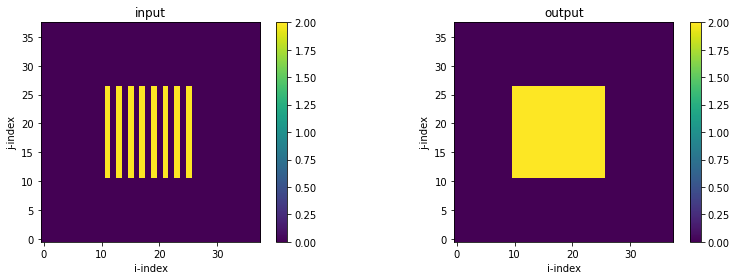

In [5]:
set_box_to_stripe_pattern(in_field, value=2.)
conditional_stencil(in_field, out_field, 1.0, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_two_ij_slices(in_field, out_field)

Alternatively, if we pass `c = -1.` the resulting field is computed using the `else` branch.

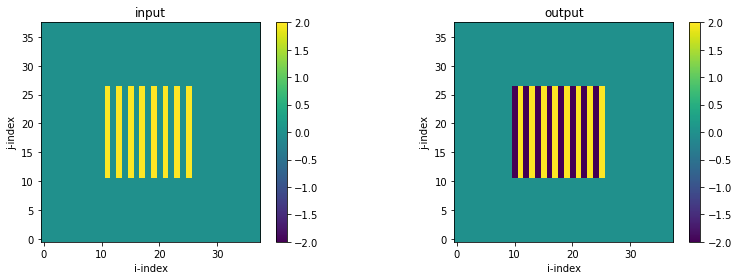

In [6]:
conditional_stencil(in_field, out_field, -1., origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_two_ij_slices(in_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you can undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px"> Replace the condition with a ternary if-clause and validate that the result is the same.</li>
        <li style="margin-bottom: 10px"> Conditionals can also be used in `gtscript.functions`. Define a function which does the same operations and call the function from the stencil.</li>
    </ol>
</div>

## Field Conditionals

Another common use-case of conditionals is when the condition is on a field, for example when writing an upwind scheme or writing a limiter to make sure no negative tracer values are encountered.

Here a simple example which computes the absolute value using a function being called from a stencil.

Are all values equal? True


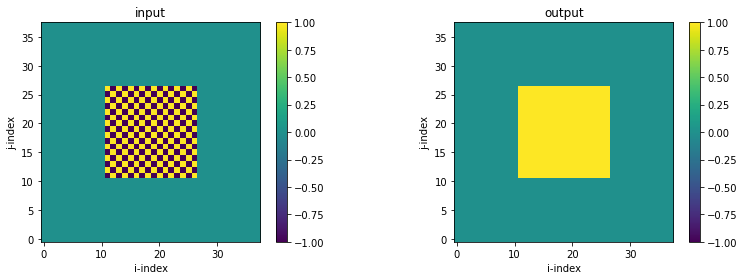

In [7]:
@gtscript.function
def absolute_value(field):
    return field if field > 0. else -field

@gtscript.stencil(backend="numpy")
def compute_absolute_value(in_field: gtscript.Field[float], out_field: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        out_field = absolute_value(in_field)

set_box_to_checkerboard_pattern(in_field, value=1.)
compute_absolute_value(in_field, out_field)

print('Are all values equal?', np.all(out_field == np.abs(in_field)))
plot_two_ij_slices(in_field, out_field)

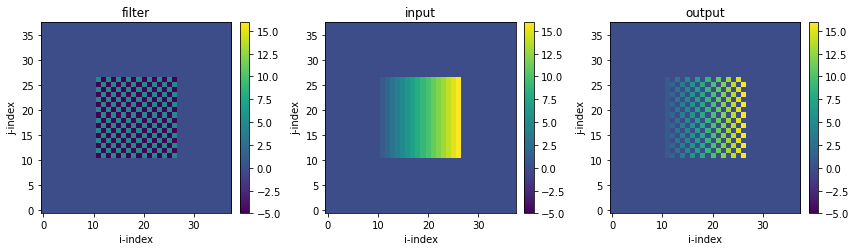

In [8]:
@gtscript.stencil(backend="numpy")
def field_conditional_stencil(
    in_field: gtscript.Field[float], out_field: gtscript.Field[float], filter_field: gtscript.Field[float]
):
    with computation(PARALLEL), interval(...):
        if filter_field[-1, 0, 0] > 0.:
            out_field = 0.
        else:
            out_field = in_field

# initialize fields
set_box_to_gradient(in_field)
out_field[:] = 0.
set_box_to_checkerboard_pattern(filter_field, value=5.)

# do the computation
field_conditional_stencil(in_field, out_field, filter_field, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_three_ij_slices(filter_field, in_field, out_field, titles=['filter', 'input', 'output'])

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">The code below implements a 4th order numerical diffusion operator. It corresponds to the Lap(Lap()) example we've looked at previously, except that the diffusive fluxes are explicitly calculated as temporaries in the code. Run it and make sure it's working.</li>
        <li style="margin-bottom: 10px">The diffusion has rather large over- and undershoots. Use conditionals to add a simple flux limiter which sets <code>flux_x</code> to zero in case <code>flux_x * (field[1, 0, 0] - field) > 0.</code> and likewise for the y-direction. Implement the limiters as <code>gtscript.function</code>s named <code>flux_limiter_x</code> and <code>flux_limiter_y</code>.</li>
        <li style="margin-bottom: 10px">Rerun and verify that the over- and undershoots have been improved.</li>
    </ol>
</div>

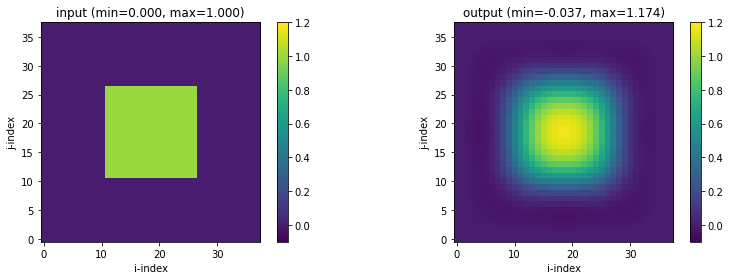

In [9]:
@gtscript.stencil(backend="numpy")
def diffusion(in_field: gtscript.Field[float], out_field: gtscript.Field[float], alpha: float):
    with computation(PARALLEL), interval(...):
        
        # Laplacian
        lap = (
            -4.0 * in_field[0, 0, 0]
            + in_field[1, 0, 0]
            + in_field[-1, 0, 0]
            + in_field[0, 1, 0]
            + in_field[0, -1, 0]
        )
        
        # diffusive fluxes
        flux_x = lap[1, 0, 0] - lap[0, 0, 0]
        flux_y = lap[0, 1, 0] - lap[0, 0, 0]
        
        # flux divergence and timestep
        out_field = in_field - alpha * (flux_x[0, 0, 0] - flux_x[-1, 0, 0] + flux_y[0, 0, 0] - flux_y[0, -1, 0])
        
        # swap time levels
        in_field = out_field
        
alpha = 1./32.
set_box_to_value(in_field)
orig_field = in_field.copy()

for i in range(500):
    diffusion(in_field, out_field, alpha, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_two_ij_slices(orig_field, out_field, titles=[
    f"input (min={np.min(orig_field):.3f}, max={np.max(orig_field):.3f})", 
    f"output (min={np.min(out_field):.3f}, max={np.max(out_field):.3f})"
])

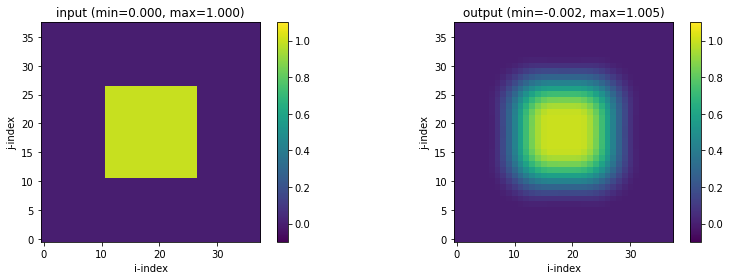

In [10]:
# REMOVE - Solution 1
@gtscript.function
def flux_limiter_x(flux_x, field):
    return 0. if flux_x * (field[1, 0, 0] - field) > 0. else flux_x


@gtscript.function
def flux_limiter_y(flux_y, field):
    return 0. if flux_y * (field[0, 1, 0] - field) > 0. else flux_y


@gtscript.stencil(backend="numpy")
def diffusion(in_field: gtscript.Field[float], out_field: gtscript.Field[float], alpha: float):
    with computation(PARALLEL), interval(...):

        # Laplacian
        lap = (
            -4.0 * in_field[0, 0, 0]
            + in_field[1, 0, 0]
            + in_field[-1, 0, 0]
            + in_field[0, 1, 0]
            + in_field[0, -1, 0]
        )
        
        # diffusive fluxes
        flux_x = lap[1, 0, 0] - lap[0, 0, 0]
        flux_y = lap[0, 1, 0] - lap[0, 0, 0]
        
        # apply flux limiter
        flux_x = flux_limiter_x(flux_x, in_field)
        flux_y = flux_limiter_y(flux_y, in_field)
        
        # flux divergence and timestep
        out_field = in_field - alpha * (flux_x[0, 0, 0] - flux_x[-1, 0, 0] + flux_y[0, 0, 0] - flux_y[0, -1, 0])
        
        # swap time levels
        in_field = out_field
        
alpha = 1./32.
set_box_to_value(in_field)
orig_field = in_field.copy()

for i in range(500):
    diffusion(in_field, out_field, alpha, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_two_ij_slices(orig_field, out_field, titles=[
    f"input (min={np.min(orig_field):.3f}, max={np.max(orig_field):.3f})",
    f"output (min={np.min(out_field):.3f}, max={np.max(out_field):.3f})"
])

## Externals and Inlining Conditionals

Any stencil arguments are either fields or scalars and are associated with storages at runtime. Anything else, however, is an external and treated as a compile-time constant. Externals are read when the stencil is decorated with `gtscript.stencil`, and the compiled code will have the value substituted. For stencils decorated with `@gtscript.stencl` compile time is when the file is read by the Python interpreter (for example when it is imported).

A simple example is shown in the code below.

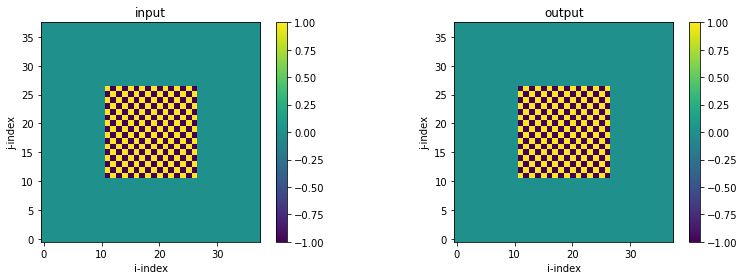

In [11]:
FLIP = 1

@gtscript.stencil(backend="numpy")
def flip_values(
    in_field: gtscript.Field[float], out_field: gtscript.Field[float]
):
    with computation(PARALLEL), interval(...):
        if FLIP == 1:
            out_field = -in_field
        else:
            out_field = in_field

set_box_to_checkerboard_pattern(in_field)
out_field[:] = 0.

flip_values(in_field, out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
plot_two_ij_slices(in_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">Try setting <code>FLIP</code> to zero to validate that the code is working as expected./li>
        <li style="margin-bottom: 10px">Use the <code>print_generate_code(flip_values)</code> method to inspect the generated Python code and find the conditional. Can you find the <code>FLIP</code> variable?</li>
        <li style="margin-bottom: 10px">Reset <code>FLIP=1</code> at the beginning of the code. Just before actually running the stencil (the <code>flip_values(...)</code> call), insert the statement <code>FLIP = 0</code>. Inspect the visualization and the generated code and check which value is actually being used. Remove the statement again.</li>
        <li style="margin-bottom: 10px">Since <code>FLIP</code> is a compile-time constant here (for example from a configuration file), we can inline it. Use the <code>__INLINED()</code> statement around the condition. Re-run the example with flipping on and off and check the generated code.</li>
        <li style="margin-bottom: 10px">Sometimes a value is not known at compile time but only at runtime. We can still use inlining to some degree, if we instead of using a decorator explicitly compile the stencil. Remove the decorator in the code above and insert code to compile the stencil. Now try moving the <code>FLIP=0/1</code> statement around in the code and check what happens.</li>
        <li style="margin-bottom: 10px">Using this strategy, it is possible to generate multiple stencils. Compile a stencil that flips (<code>flip_values</code>) and one that does not flip (<code>noflip_values</code>) by setting <code>FLIP</code> correspondingly before compling each stencil separately.</li>
    </ol>
</div>

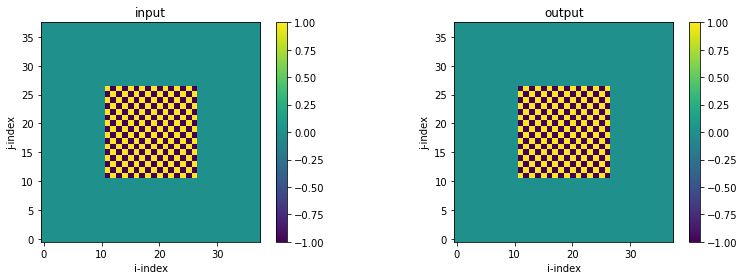

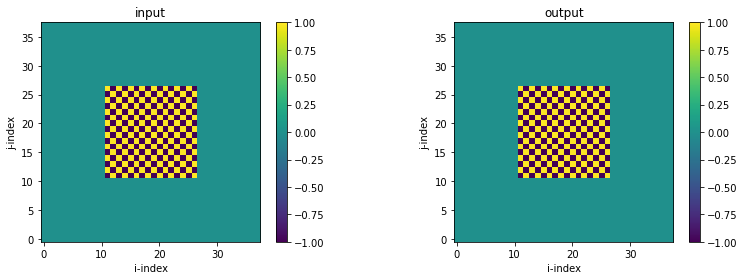

In [12]:
# REMOVE - Solution
del FLIP

def flip_values_def(
    in_field: gtscript.Field[float], out_field: gtscript.Field[float]
):
    with computation(PARALLEL), interval(...):
        if __INLINED(FLIP == 1):
            out_field = -in_field
        else:
            out_field = in_field

set_box_to_checkerboard_pattern(in_field)
out_field[:] = 0.

FLIP = 1
flip_values = gtscript.stencil("numpy", flip_values_def)

FLIP = 0
noflip_values = gtscript.stencil("numpy", flip_values_def)

flip_values(in_field, out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
plot_two_ij_slices(in_field, out_field)

noflip_values(in_field, out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
plot_two_ij_slices(in_field, out_field)

The main reason of inlining externals at compile-time is performance. Inlining often significantly simplifies the code and allows for much more aggressive inlining and fusion. Since Python effective shifts compile-time inlining to just-in-time, this strategy of compiling stencils with different externals is an efficient way of achieving good performance while being able to write re-usable code which can serve multiple purposes.

It should be noted that in principle GT4Py could automatically inline conditionals if the values can be evaluated at compile-time and the `__INLINED()` construct is not strictly necessary. But automatic inlining can be slightly dangerous in a dynamic language such as Python and we have thus - for the time being - decided to make inlining explicit in the DSL language.

GT4Py also provides an `externals` dictionary through which externals can be passed. This has the advantage of being a more explicit interface (making the import of the external apparent in the code) and also providing the possibility of renaming.

Let's re-use the diffusion code from above (reproduced below including the flux limiter for convenience).

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">Remove the decorator from <code>diffusion</code> and explictly compile the stencil using <code>gtscript.stencil()</code>. Check that everything still runs ok.</li>
        <li style="margin-bottom: 10px">Before compilation, define an variable <code>flux_limiter_on = True</code>. Then add an extra keyword argument to the <code>gtscript.stencil(..., externals={"FLUX_LIMITER_ON": flux_limiter_on})</code> call. You can now <code>from __externals__ import FLUX_LIMITER_ON</code> in the stencil definition and add a conditional statement <code>if __INLINED(FLUX_LIMITER_ON):</code> around the call of the x- and y-flux limiters. Run your code and try switching the flux limiters on and off.</li>
        <li style="margin-bottom: 10px">Externals can also be used to write more modular code and remove switch/case statements in performance critical parts of the code. Just before compiling the stencil, define <code>limiter_x = flux_limiter_x</code> and <code>limiter_y = flux_limiter_y</code> and add these to the externals dictionary without changing their names. Now import them inside the stencil and replace the explicit function calls to <code>flux_limiter_x</code> and <code>flux_limiter_y</code> with the generic versions. Implement a <code>gtscript.function</code> named <code>no_limiter(flux, field)</code> which simply does a <code>return flux</code>. You can now swap out the different flux limiters. For fun, you can also try switching the x- and y-direction limiters to see what happens.</li>
        <li style="margin-bottom: 10px"></li>
    </ol>
</div>

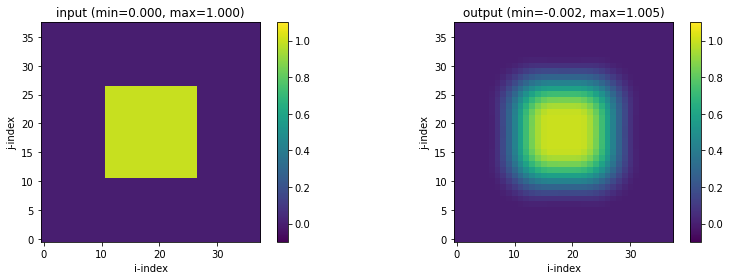

In [14]:
# REMOVE - Solution
@gtscript.function
def no_limiter(flux, field):
    return flux

@gtscript.function
def flux_limiter_x(flux_x, field):
    return 0. if flux_x * (field[1, 0, 0] - field) > 0. else flux_x


@gtscript.function
def flux_limiter_y(flux_y, field):
    return 0. if flux_y * (field[0, 1, 0] - field) > 0. else flux_y


def diffusion_def(in_field: gtscript.Field[float], out_field: gtscript.Field[float], alpha: float):
    from __externals__ import FLUX_LIMITER_ON, limiter_x, limiter_y
    with computation(PARALLEL), interval(...):

        # Laplacian
        lap = (
            -4.0 * in_field[0, 0, 0]
            + in_field[1, 0, 0]
            + in_field[-1, 0, 0]
            + in_field[0, 1, 0]
            + in_field[0, -1, 0]
        )
        
        # diffusive fluxes
        flux_x = lap[1, 0, 0] - lap[0, 0, 0]
        flux_y = lap[0, 1, 0] - lap[0, 0, 0]
        
        # apply flux limiter
        if __INLINED(FLUX_LIMITER_ON):
            flux_x = limiter_x(flux_x, in_field)
            flux_y = limiter_y(flux_y, in_field)
        
        # flux divergence and timestep
        out_field = in_field - alpha * (flux_x[0, 0, 0] - flux_x[-1, 0, 0] + flux_y[0, 0, 0] - flux_y[0, -1, 0])
        
        # swap time levels
        in_field = out_field

flux_limiter_on = True
limiter_x = flux_limiter_x
limiter_y = flux_limiter_y
diffusion = gtscript.stencil("numpy", diffusion_def, externals={"FLUX_LIMITER_ON": flux_limiter_on, "limiter_x": limiter_x, "limiter_y": limiter_y})
        
alpha = 1./32.
set_box_to_value(in_field)
orig_field = in_field.copy()

for i in range(500):
    diffusion(in_field, out_field, alpha, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))
plot_two_ij_slices(orig_field, out_field, titles=[
    f"input (min={np.min(orig_field):.3f}, max={np.max(orig_field):.3f})",
    f"output (min={np.min(out_field):.3f}, max={np.max(out_field):.3f})"
])

To finish this section on externals and inlining, we measure performance of a simple code example with and without externals and inlining to demonstrate the performance impact. It should be noted that while the performance difference observed below using the CPU backend may not seem very significant, the picture may change significantly for more complex code examples as well as on GPUs, which have much less complex logic for branch prediction, prefetching and integer computations.

In [17]:
C = 1.0

@gtscript.stencil(backend="gtx86")
def inlined_conditional_stencil(in_field: gtscript.Field[float], out_field: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        if __INLINED(C > 0.):
            out_field = in_field + in_field[1, 0, 0]
        else:
            out_field = 0.0

@gtscript.stencil(backend="gtx86")
def conditional_stencil(in_field: gtscript.Field[float], out_field: gtscript.Field[float], c: float):
    with computation(PARALLEL), interval(...):
        if c > 0.:
            out_field = in_field + in_field[1, 0, 0]
        else:
            out_field = 0

# Setting up the domain
ni = nj = 256
nk = 1
nhalo = 3

# and the storages
in_field = gt4py.storage.zeros(
    shape = (ni + 2*nhalo, nj + 2*nhalo, nk),
    default_origin = (0, 0, 0),
    dtype = float,
    backend = "gtx86",
)
out_field = in_field.copy()

#Timing the regular stencil:
print("Runtime conditional:")
%timeit conditional_stencil(in_field, out_field, C, origin=(nhalo, nhalo, 0), domain=(ni, nj, nk))
print("Inlined conditional:")
%timeit inlined_conditional_stencil(in_field, out_field, origin=(nhalo, nhalo, 0), domain=(ni, nj, nk))

Runtime conditional:
1.07 ms ± 742 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Inlined conditional:
934 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Wrapping Up

This notebook introduced conditionals and externals as additional GT4Py concepts. The following problems serve as a wrap-up exercise where many of the concepts have to be applied.

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">Write a <code>fill_horizontal</code> stencil function to fill sparse, small negative values in the input fields using neighboring values along the i-direction. Does your solution work if the first or last value is negative?</li>
        <li style="margin-bottom: 10px">Starting from <code>fill_horizontal</code>, write a <code>fill_horizontal_direction</code> stencil function that can fill along the i or j directions based on a run-time conditional.
        <li style="margin-bottom: 10px">Adapt the <code>fill_horizontal_direction</code> stencil function into <code>fill_horizontal_inlined</code> so that the direction is specified at compiletime
        <li style="margin-bottom: 10px">Open the <code>.gt_cache</code> directory and inspect the generated code.</li>
    </ol>
</div>

In [18]:
# Solution 1
@gtscript.stencil(backend="numpy")
def fill_horizontal(
    in_field: gtscript.Field[float]
):
    with computation(PARALLEL), interval(...):
        in_field = in_field

in_field_1 = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
in_field_1[nhalo + nx // 3 : nhalo + 2 * nx // 3, nhalo + ny // 3 : nhalo + 2 * ny // 3, :] = 3.
in_field_1[nhalo + nx // 3 : nhalo + 2 * nx // 3 : 2, nhalo + ny // 3 : nhalo + 2 * ny // 3, :] = -1.

in_copy = in_field_1.copy()
    

print(in_field_1[:, nhalo + ny//2, 0], np.mean(in_field_1))

fill_horizontal(in_copy, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
    
print(in_copy[:, nhalo + ny//2, 0], np.mean(in_copy))

plot_two_ij_slices(in_field_1, in_copy)

IndexError: index 45 is out of bounds for axis 1 with size 38

In [ ]:
# Solution 2            
@gtscript.stencil(backend="numpy")
def fill_horizontal_direction(
    in_field: gtscript.Field[float], fill_direction: int
):
    with computation(PARALLEL), interval(...):
        in_field = in_field

in_field_2 = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

in_field_2[nhalo + nx // 3 : nhalo + 2 * nx // 3, nhalo + ny // 3 : nhalo + 2 * ny // 3, :] = 3
in_field_2[nhalo + nx // 3 : nhalo + 2 * nx // 3, nhalo + ny // 3 : nhalo + 2 * ny // 3 : 2, :] = -1

in_copy = in_field_2.copy()

print(in_field_2[nhalo + nx//2, :, 0], np.mean(in_field_2))

fill_horizontal_direction(in_copy, -1, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
    
print(in_copy[nhalo + nx//2, :, 0], np.mean(in_copy))

plot_two_ij_slices(in_field_2, in_copy)

In [ ]:
# Solution 3
DIR = -1

@gtscript.stencil(backend="numpy")
def fill_horizontal_inlined(in_field: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        in_field = in_field

in_copy = in_field_2.copy()

print(in_field_2[nhalo + nx//2, :, 0], np.mean(in_field_2))

fill_horizontal_inlined(in_copy, origin=(nhalo, nhalo, 0), domain=(nx, ny, 1))
    
print(in_copy[nhalo + nx//2, :, 0], np.mean(in_copy))

plot_two_ij_slices(in_field_2, in_copy)

In [ ]:
def avg(a: gtscript.Field[float], b: gtscript.Field[float]):
    from __externals__ import OFFSET
    with computation(PARALLEL), interval(...):
        a = 0.5 * (b + b[OFFSET, 0, 0])

stencil_call_1 = gtscript.stencil(
    definition = avg,
    externals = {"OFFSET": 2},
    backend = "numpy"
)

in_field_1 = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
in_field_1[nhalo + nx // 3 : nhalo + 2 * nx // 3, nhalo + ny // 3 : nhalo + 2 * ny // 3, :] = 3
in_field_1[nhalo + nx // 3 : nhalo + 2 * nx // 3 :2, nhalo + ny // 3 : nhalo + 2 * ny // 3, :] = -1

out_field = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

stencil_call_1(out_field, in_field_1, origin=(nhalo-1, nhalo-1, 0), domain=(nx+1, ny+1, 1))

plot_two_ij_slices(in_field_1, out_field)